**With this project i'm going to build a model in order to predict Nicaragua's central government income taxes. The data source for this data is Banco Central de Nicaragua (2003-2015) and Ministerio de Hacienda y Credito Publico (2016-2022).**

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.simplefilter(action='ignore')
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Import the data

In [22]:
cgtaxesnic = pd.read_csv('/.nicataxes.csv')
cgtaxesnic

,Month,Amount
0,2003,"9,422.4"
1,NaN,NaN
2,Enero,742.3
3,Febrero,701.7
4,Marzo,832.8
...,...,...
298,NaN,NaN
299,NaN,NaN
300,NaN,NaN
301,NaN,NaN


# The Cleaning process

Treating null values

In [23]:
cgtaxesnic.isna().sum()

Month     43
Amount    43
dtype: int64

In [24]:
cgtaxesnic.dropna(inplace=True)
print(cgtaxesnic)
print(cgtaxesnic.isna().sum())

          Month     Amount
0          2003   9,422.4 
2         Enero     742.3 
3       Febrero     701.7 
4         Marzo     832.8 
5         Abril     666.7 
..          ...        ...
293      Agosto   8,939.7 
294  Septiembre   8,588.2 
295     Octubre   8,886.3 
296   Noviembre   9,015.1 
297   Diciembre   9,127.7 

[260 rows x 2 columns]
Month     0
Amount    0
dtype: int64


Cleaning the Month column

In [25]:
cgtaxesnic['Month'].unique()

array(['2003', 'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
       'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre',
       'Diciembre', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020', '2021', '2022'], dtype=object)

In [26]:
cleancgtaxesnic = cgtaxesnic[cgtaxesnic['Month'].str.contains('\D+')]
cleancgtaxesnic.Month.unique()

array(['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio',
       'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'],
      dtype=object)

In [27]:
cleancgtaxesnic.Month.value_counts()

Month
Enero         20
Febrero       20
Marzo         20
Abril         20
Mayo          20
Junio         20
Julio         20
Agosto        20
Septiembre    20
Octubre       20
Noviembre     20
Diciembre     20
Name: count, dtype: int64

After cleaning the Month column, is necessary to have a date range for our data

In [28]:
cleancgtaxesnic['Date'] = pd.date_range(start='2003/1/1/', end='2022/12/31', freq='M')

Now, checking if there is any null values and the data types of our columns

In [29]:
print(cleancgtaxesnic.isna().sum())
print(cleancgtaxesnic.dtypes)

Month     0
Amount    0
Date      0
dtype: int64
Month             object
Amount            object
Date      datetime64[ns]
dtype: object


As we can see, there is no null values, but the Amount column is an object, and should be float. We are going to change this.

In [30]:
cleancgtaxesnic['Amount']=cleancgtaxesnic['Amount'].str.replace(',','').str.strip()

In [31]:
cleancgtaxesnic['Amount']=cleancgtaxesnic['Amount'].astype("float")

In [32]:
cleancgtaxesnic.dtypes

Month             object
Amount           float64
Date      datetime64[ns]
dtype: object

Once we have the right data type, We'll convert the date column into our index.

In [34]:
cleancgtaxesnic = cleancgtaxesnic.set_index('Date')
cleancgtaxesnic.drop('Month',axis=1, inplace=True)
cleancgtaxesnic

,Amount
Date,
2003-01-31,742.3
2003-02-28,701.7
2003-03-31,832.8
2003-04-30,666.7
2003-05-31,741.6
...,...
2022-08-31,8939.7
2022-09-30,8588.2
2022-10-31,8886.3


# The EDA

In this part, I'm going to find if the TS is stationary or not, and if it needs some kind of transformation.

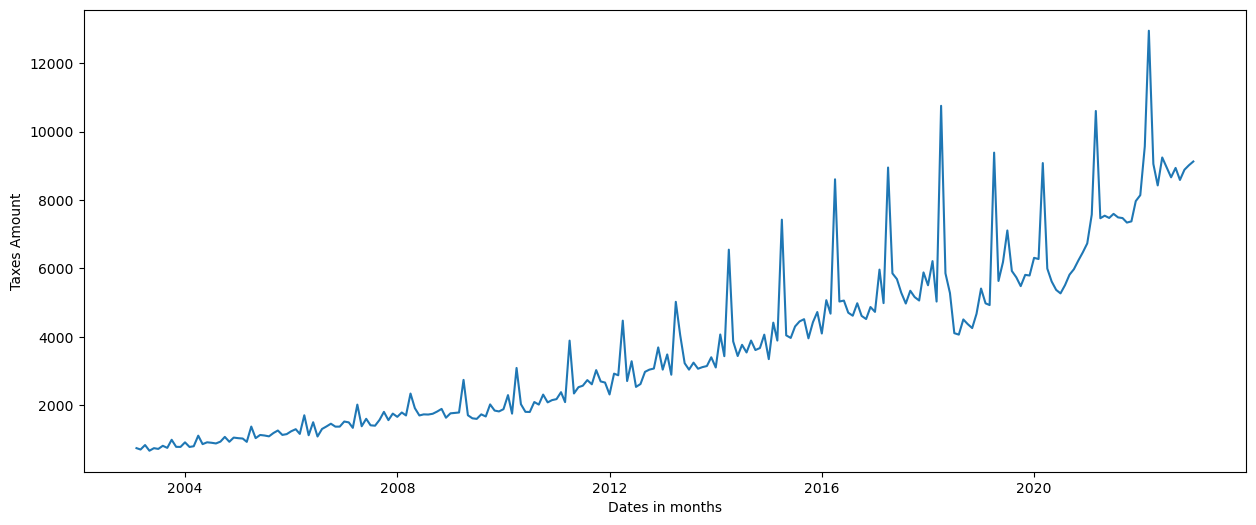

In [35]:
plt.figure(figsize=(15,6))
plt.plot(cleancgtaxesnic.index, cleancgtaxesnic['Amount'])
plt.xlabel('Dates in months')
plt.ylabel('Taxes Amount')
plt.show()

The plot above shows two things: a trend, and a difference variance of the values along the period of time. So clearly the Series is not stationary. Also, there are some peaks that show some kind of seasonality. We are going to run a seasonal decompose plot and a ADF test to confirm that our Series is not stationary and has a sesonality.

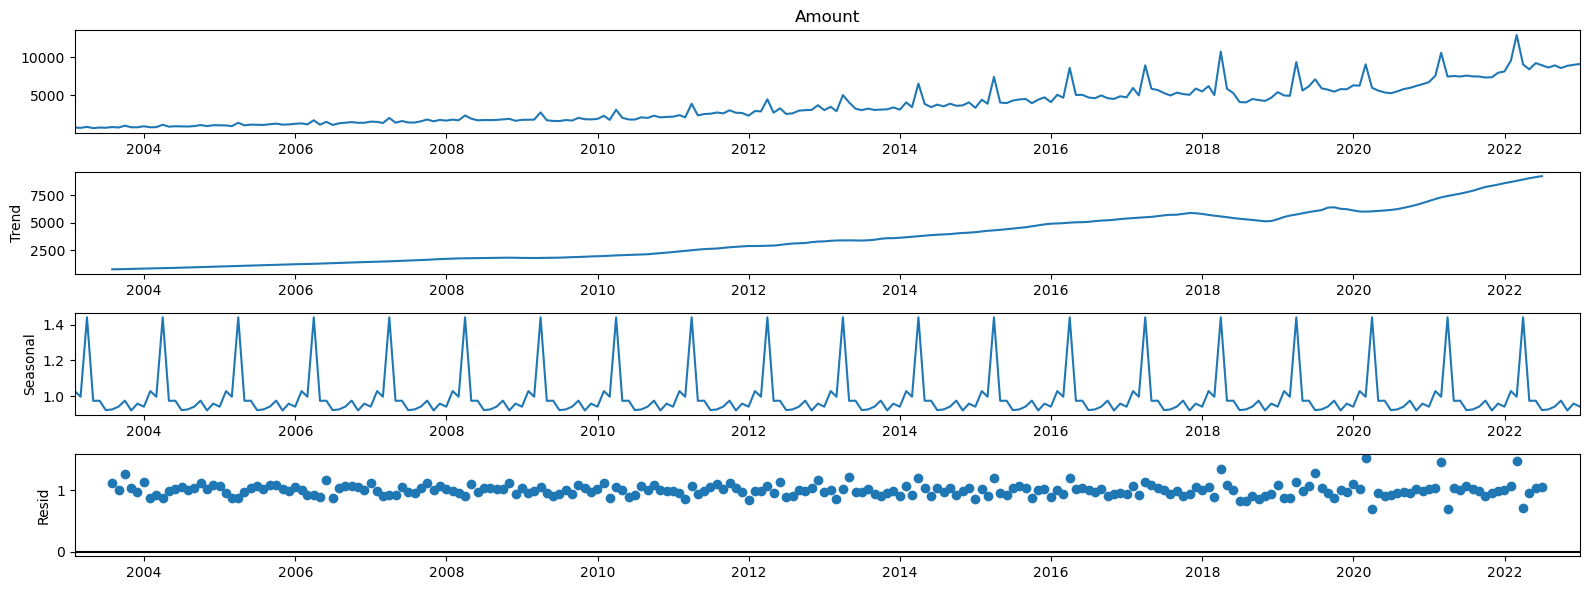

In [37]:
# plot decomposition with frequency 36
from statsmodels.tsa.seasonal import seasonal_decompose

fig = seasonal_decompose(cleancgtaxesnic.Amount, model='multiplicative').plot()
fig.set_size_inches((16, 6))
fig.tight_layout()
plt.show()

In [38]:
# define Augmented Dickey-Fuller Test (ADFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [39]:
dftest(cleancgtaxesnic.Amount)

Test Statistic            2.107263
p-value                   0.998797
Lags Used                13.000000
Observations Used       226.000000
Critical Value (1%)      -3.459620
Critical Value (5%)      -2.874415
Critical Value (10%)     -2.573632
dtype: float64


As we can see, the seasonal decompose plot clearly shows the season component of our TS, with a repeated peak along the years.
Also, the ADF Test confirm that our TS is not stationary, and will need some kind of transformation.

<AxesSubplot:xlabel='Date', ylabel='Amount'>

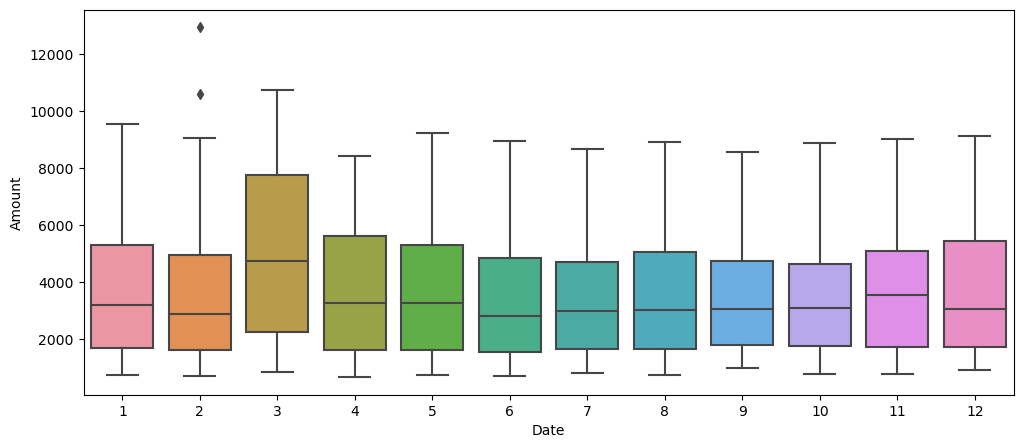

In [43]:
plt.figure(figsize=(12,5))
sns.boxplot(x=cleancgtaxesnic.index.month, y=cleancgtaxesnic.Amount)

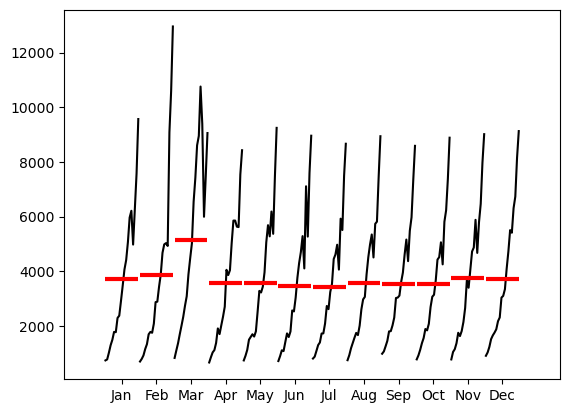

In [46]:
fig = sm.graphics.tsa.month_plot(cleancgtaxesnic.Amount)

Another way to detect the seasonality is with a BoxPlot and a month plot (is built on the statsmodel package). It clearly shows that the median of the values is higher in March (3).
**Looks like in March we have the seasonality, the reason is that in Nicaragua by that time companies declare income taxes.**

# Transformations

**In order to know which is the transformation that we need to implement to make stationary the TS, I'm going to Plot 5 types of transformations: diff (1 and 12 lag), log transform, and log transform differencing (1 and 12 lag.**

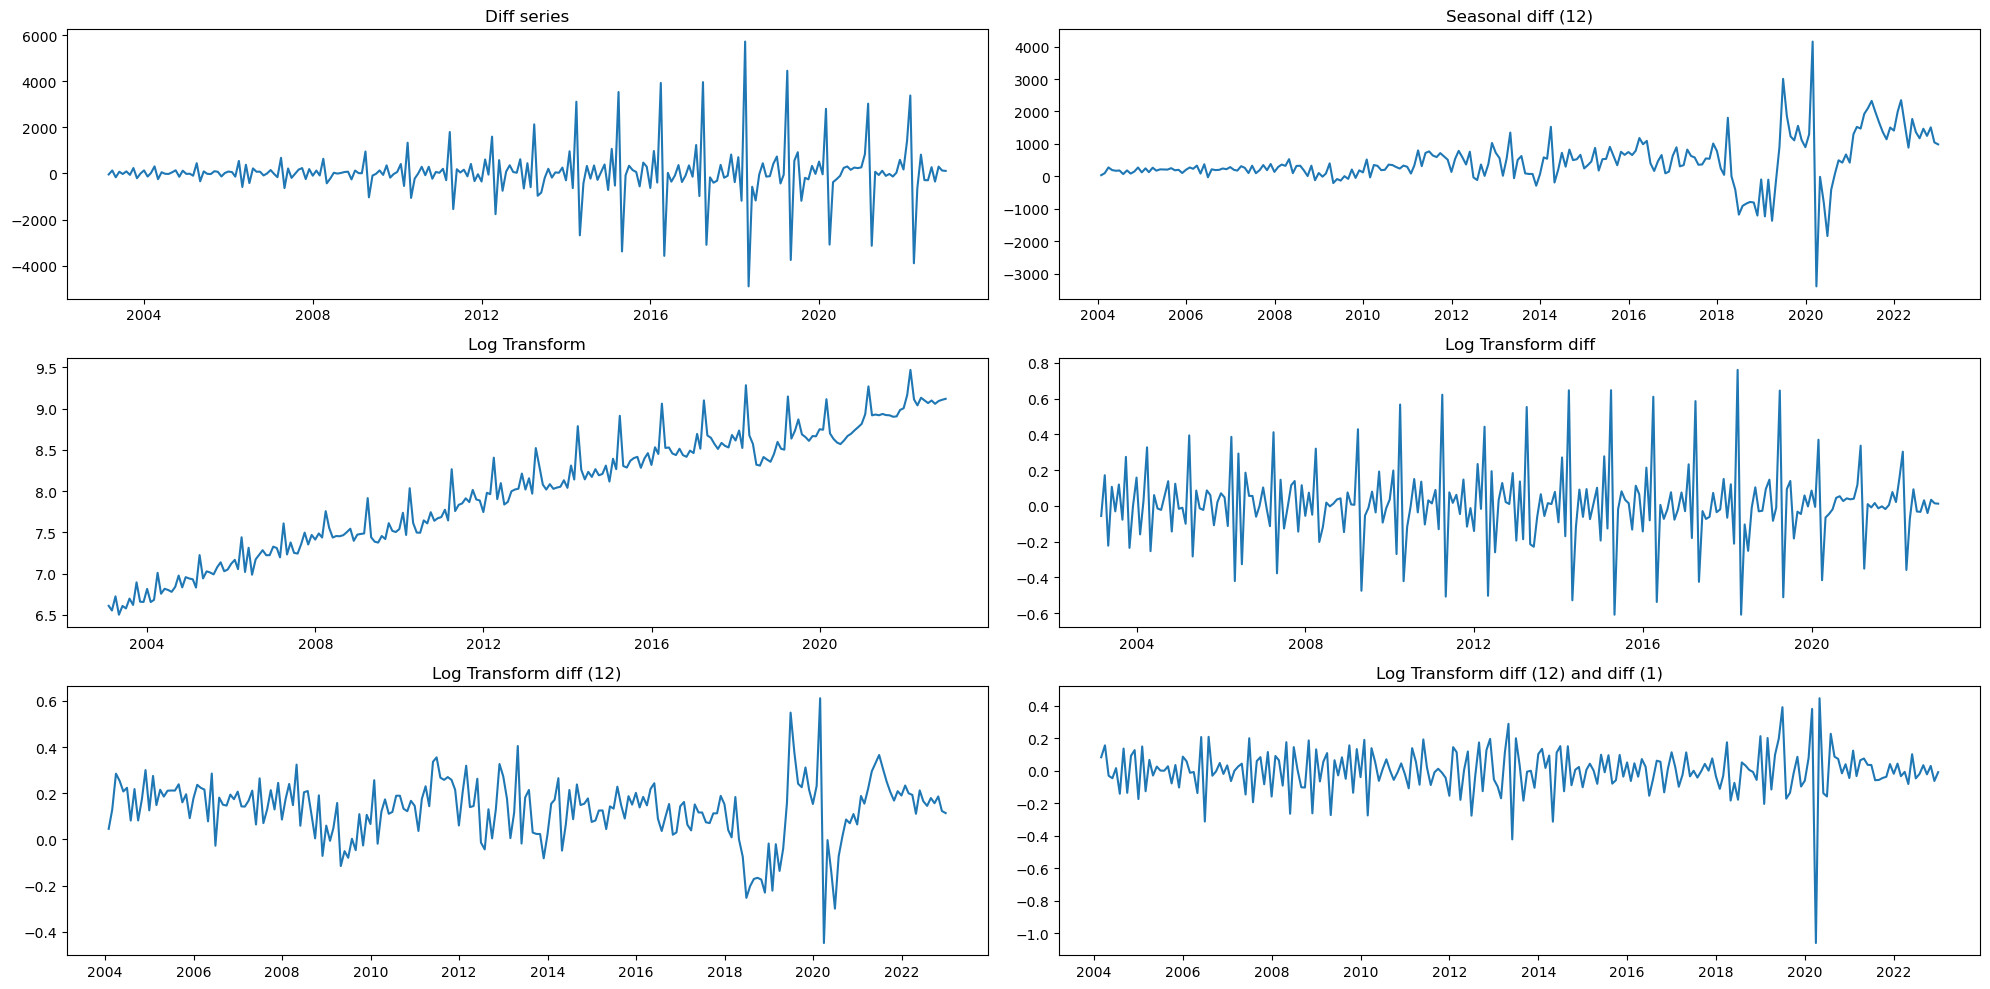

In [77]:
fig, axes = plt.subplots(3,2, figsize = (20,10))

axes[0,0].plot(cleancgtaxesnic.index,cleancgtaxesnic['Amount'].diff(), label='diff series')
axes[0,0].set_title('Diff series')
axes[0,1].plot(cleancgtaxesnic.index,cleancgtaxesnic.Amount.diff(periods=12))
axes[0,1].set_title('Seasonal diff (12)')
axes[1,0].plot(cleancgtaxesnic.index, np.log(cleancgtaxesnic.Amount))
axes[1,0].set_title('Log Transform')
axes[1,1].plot(cleancgtaxesnic.index,np.log(cleancgtaxesnic.Amount).diff())
axes[1,1].set_title('Log Transform diff')
axes[2,0].plot(cleancgtaxesnic.index,np.log(cleancgtaxesnic.Amount).diff(periods=12))
axes[2,0].set_title('Log Transform diff (12)')
axes[2,1].plot(cleancgtaxesnic.index,np.log(cleancgtaxesnic.Amount).diff(periods=12).diff())
axes[2,1].set_title('Log Transform diff (12) and diff (1)')
plt.tight_layout() # To not get overlap between the axis names and the titles of a different plots

**According with the plots, when transforming to log, the TS stabilizes a little but still has a trend. When Applying lag 1 difference the trend dissapeared but we still have like a sesonality patron. When we apply seasonality difference (12) to the original TS, we see that the trend dissapeared, but still has a non constant variance. So, then I Applied another lag 1 difference, and I get a more stable TS, with Stationarity. We are going to run the ADF Test for the log Series with the lag 1 difference and with  the seasonal difference and the seasonal and lag 1 difference.**

In [47]:
dftest(np.log(cleancgtaxesnic.Amount).diff().dropna())

Test Statistic           -4.642954
p-value                   0.000108
Lags Used                13.000000
Observations Used       225.000000
Critical Value (1%)      -3.459752
Critical Value (5%)      -2.874473
Critical Value (10%)     -2.573663
dtype: float64


In [49]:
dftest(np.log(cleancgtaxesnic.Amount).diff(12).dropna())

Test Statistic           -3.124755
p-value                   0.024775
Lags Used                13.000000
Observations Used       214.000000
Critical Value (1%)      -3.461282
Critical Value (5%)      -2.875143
Critical Value (10%)     -2.574020
dtype: float64


In [50]:
dftest(np.log(cleancgtaxesnic.Amount).diff(12).diff().dropna())

Test Statistic         -7.514521e+00
p-value                 3.935313e-11
Lags Used               1.400000e+01
Observations Used       2.120000e+02
Critical Value (1%)    -3.461578e+00
Critical Value (5%)    -2.875272e+00
Critical Value (10%)   -2.574089e+00
dtype: float64


**SO, ACORDING WITH THE PLOTS AND THE ADF TEST, WE CAN SAY THAT THERE ARE TWO BEST TRANSFORMATION: THE ONE WITH LOG AND MAKING LAG 1 DIFFERENCE; AND DOING JUST A LAG 1 DIFFERENCE TO THE LOG SERIES**

# Selecting the parameters for our model

**SINCE I DECIDED THAT THE BEST TS TRANSFORMATIONS WAS THE LOG WITH SEASONAL AND FIRST DIFFERENCE, AND IN ORDER TO PICK THE PARAMETERS OF THE SARIMA MODEL, IT IS NECESSARY TO PLOT THE ACF AND PACF PLOT TO SEE IF CAN BE CHOOSEN MANUALLY**

In [52]:
# Creating a function to plot ACF and PACF
def plots(data, lags=None):
    plt.figure(figsize=(16,5))
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

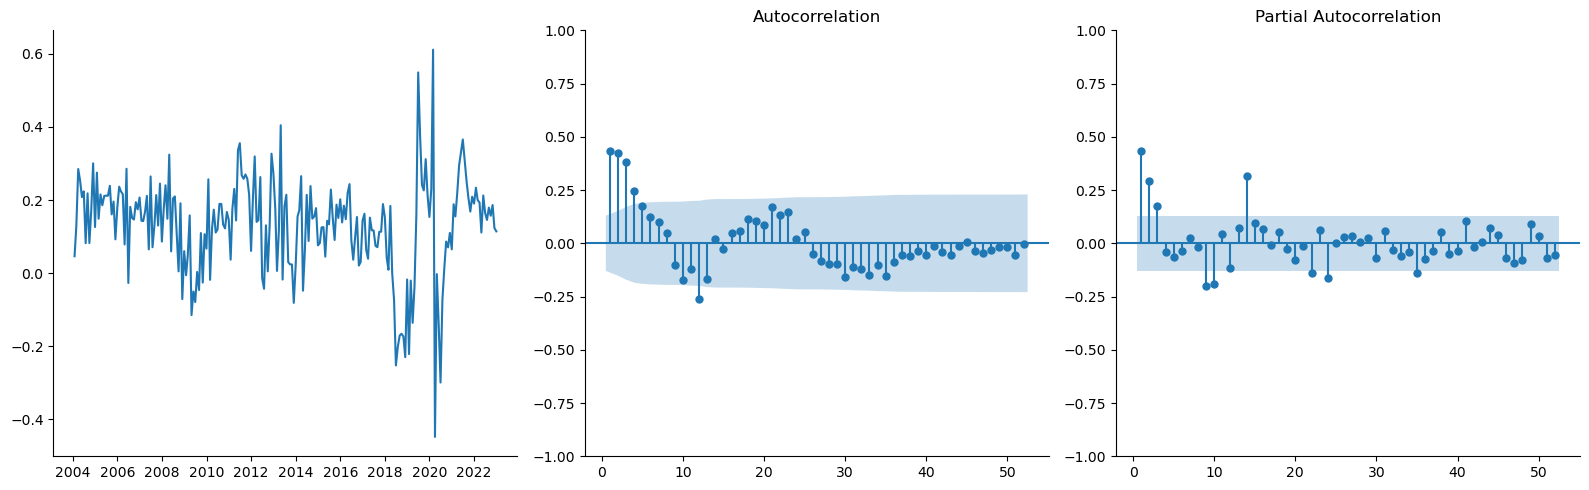

In [53]:
plots(np.log(cleancgtaxesnic.Amount).diff(periods=12).dropna(), lags=52);

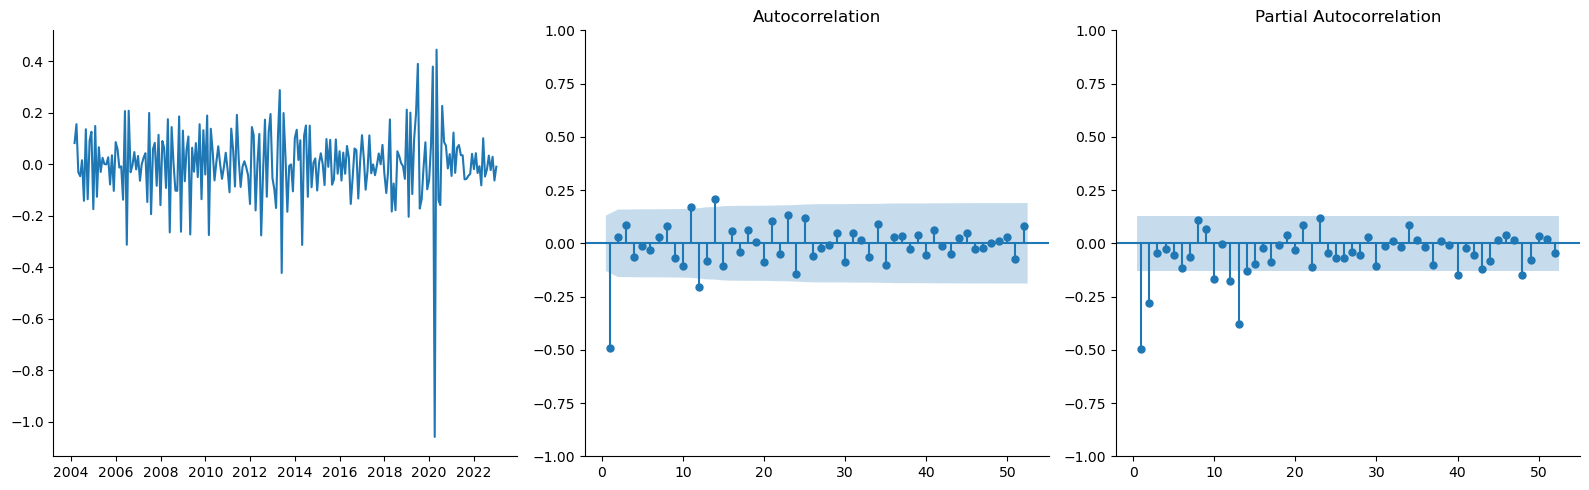

In [54]:
plots(np.log(cleancgtaxesnic.Amount).diff(periods=12).diff().dropna(), lags=52);

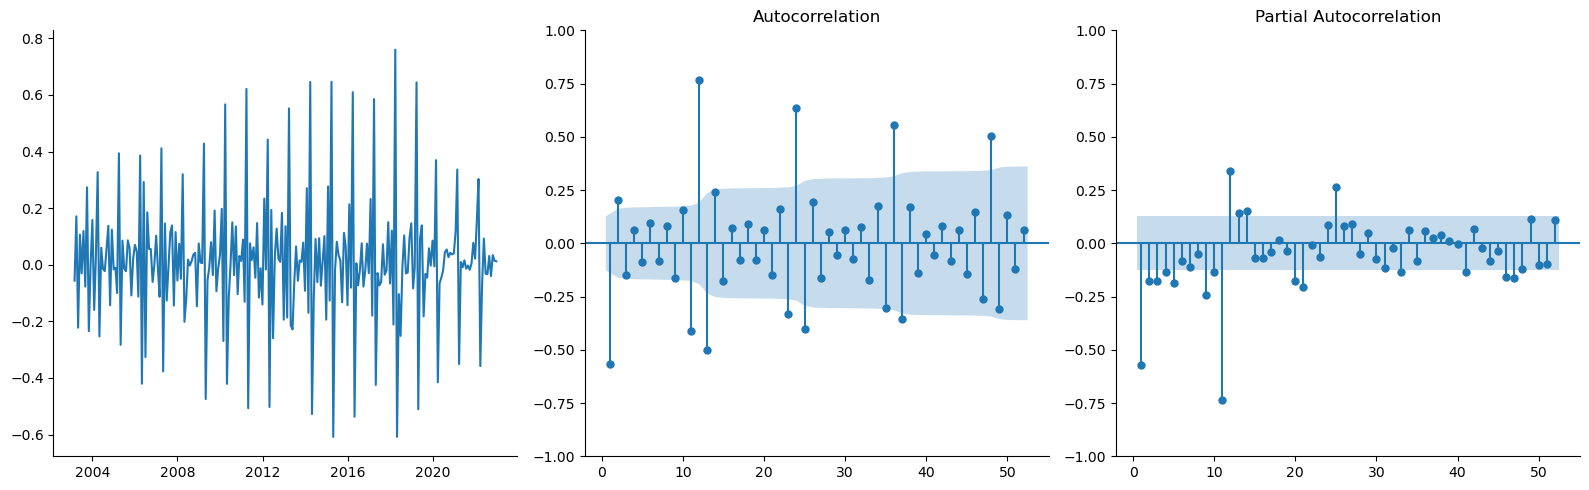

In [106]:
plots(np.log(cleancgtaxesnic.Amount).diff().dropna(), lags=52);

**The above plots, let us know that we have a possible MA model, but it could be an AR model, too. If we check the second plot, the PACF and the ACF plot presents in the seasonal lags one significant spike; in the non seasonal spikes, we have possible an MA(1), because the spikes are decaying in PACF, and just the first one is significant in the ACF. BUT WE ARE GOING TO CHECK WITH THE AUTOARIMA MODEL**

# Building the model
**We are going to run 3 differents models: 1) with seasonal difference and lag 1 differencen, 2) With autoarima letting choose the order of differencing, and 3) Just with a seasonal difference.** 

## Model 1: D=1 and d=1

In [55]:
automodel = pm.auto_arima(np.log(cleancgtaxesnic.Amount),
                           error_action='ignore', m=12, D=1, d=1,
                           start_P=0,
                           start_q=0, start_Q=0, start_p=0,
                           suppress_warnings=True, seasonal=True,
                           stepwise=True, trace=True)
print(automodel.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-241.843, Time=1.71 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-319.743, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-351.755, Time=0.24 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-320.236, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-350.226, Time=0.34 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-350.187, Time=1.06 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-343.786, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=3.06 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-254.607, Time=0.15 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-351.918, Time=0.29 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-319.558, Time=0.06 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-350.270, Time=0.51 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-350.243, Time=1.82 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-343.922, Time=0.20 sec
 ARIMA(1,1,1)(1,1,2)[12]

In [56]:
model1 = sm.tsa.statespace.SARIMAX(np.log(cleancgtaxesnic.Amount),
                                order=(1,1,1),
                                seasonal_order=(0, 1, 1, 12))
results1 = model1.fit()
print(results1.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.35784D-01    |proj g|=  1.11830D+00

At iterate    5    f= -7.43892D-01    |proj g|=  6.10604D-01

At iterate   10    f= -7.49330D-01    |proj g|=  4.40274D-02

At iterate   15    f= -7.49830D-01    |proj g|=  1.37698D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     24      1     0     0   3.242D-04  -7.498D-01
  F = -0.74983016591359275     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


                                     SARIMAX Results                                      
Dep. Variable:                             Amount   No. Observations:                  240
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 179.959
Date:                            Wed, 24 May 2023   AIC                           -351.918
Time:                                    20:51:24   BIC                           -338.219
Sample:                                01-31-2003   HQIC                          -346.390
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1588      0.096     -1.655      0.098      -0.347       0.029
ma.L1         -0.6006      0.094   

**As we can see, all the p values of the coefficients are significant. But lets look at the residual diagnostics plot and other tests**

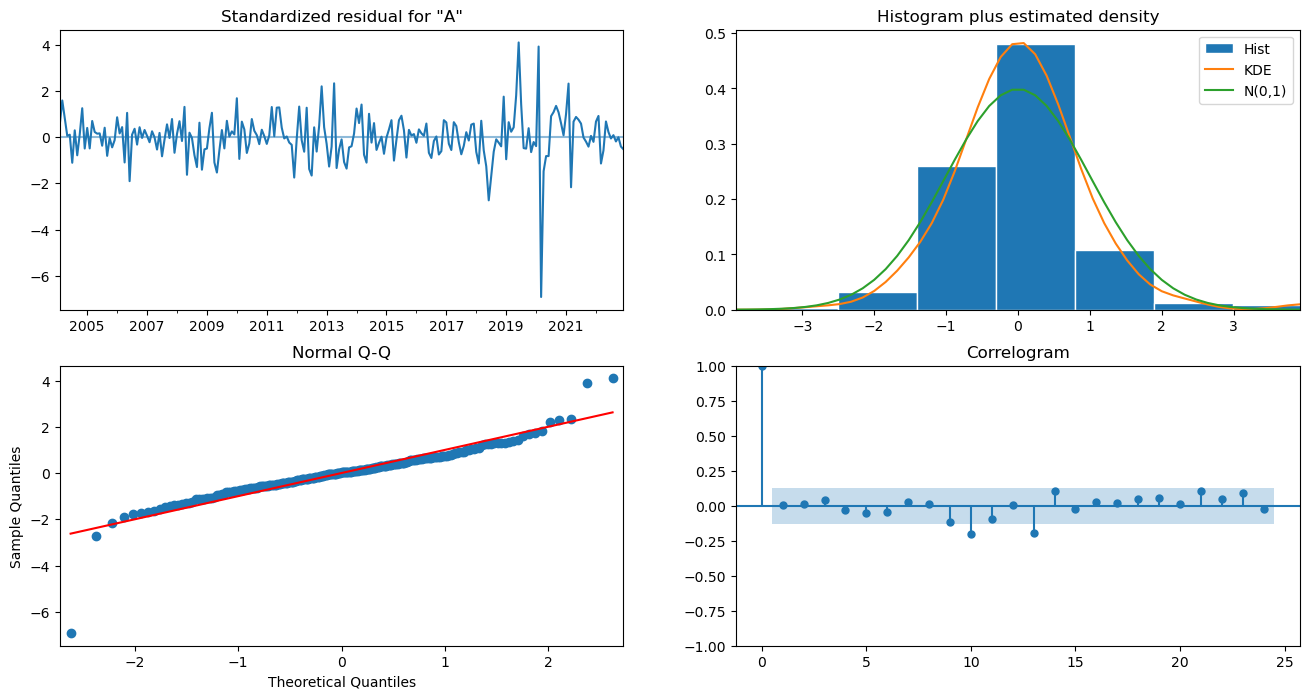

In [57]:
results1.plot_diagnostics(figsize=(16,8), lags=24)
plt.show()

In [58]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = results1.test_normality('jarquebera')[0]
lb_val, lb_p = results1.test_serial_correlation(method='ljungbox',)[0]
het_val, het_p = results1.test_heteroskedasticity('breakvar')[0]


# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(
    results1.filter_results.standardized_forecasts_error[0, results1.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=1142.109, p=0.000
Ljung-Box: val=36.236, p=0.052
Heteroskedasticity: val=3.401, p=0.000
Durbin-Watson: d=1.99


**All results, except for Normality test, says that the residuals are good: no serial correlations, and no heterokedasticity. The normal distribution could be because of some extreme (outliers) values because of the crisis in Nicaragua (political crisis and COVID-19 what produced a economic crisis).**

### Get predictions

In [73]:
print(len(cleancgtaxesnic)*.85)
print(cleancgtaxesnic.iloc[204])

204.0
Amount    6274.6
Name: 2020-01-31 00:00:00, dtype: float64


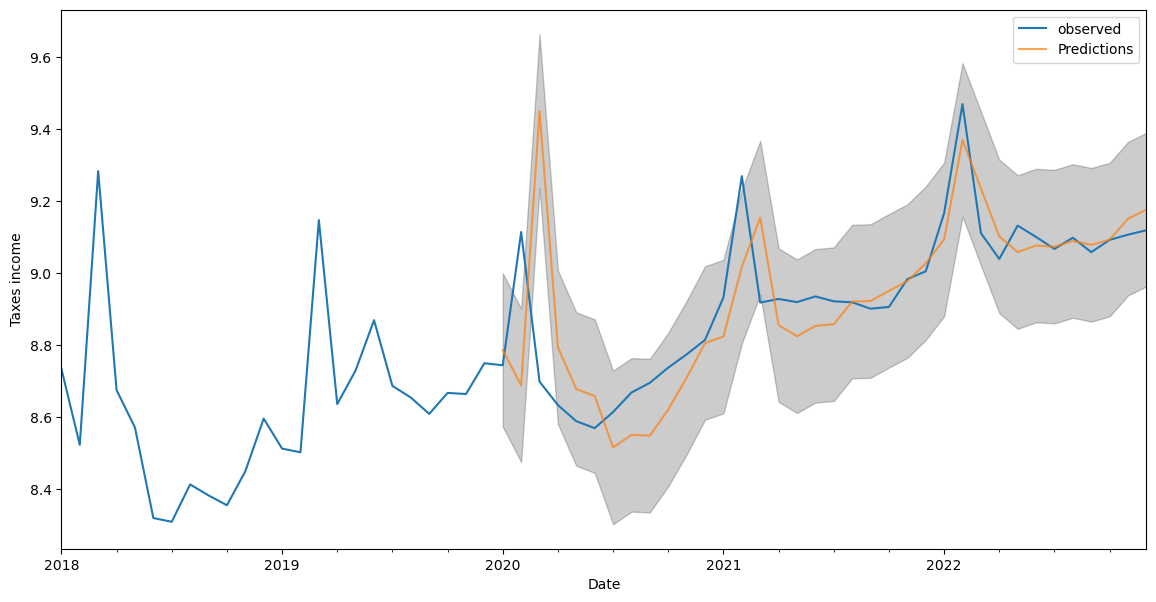

In [74]:
pred = results1.get_prediction(start=pd.to_datetime('2020-01-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = np.log(cleancgtaxesnic.Amount)['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Predictions', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Taxes income')
plt.legend()
plt.show()

In [75]:
y_forecasted = pred.predicted_mean
y_truth = np.log(cleancgtaxesnic.Amount)['2020-01-31':]

# Compute the mean square error
mape1 = np.mean(np.abs(y_forecasted - y_truth)/np.abs(y_truth))
print('Mean Absolute Percentage Error is {}'.format(round(mape1, 4)))

Mean Absolute Percentage Error is 0.0116


In [76]:
print('MSE IS: ', results1.mse)
print('RMSE IS: ', np.sqrt(results1.mse))

MSE IS:  0.24445594711287252
RMSE IS:  0.4944248649824081


### Get the forecast

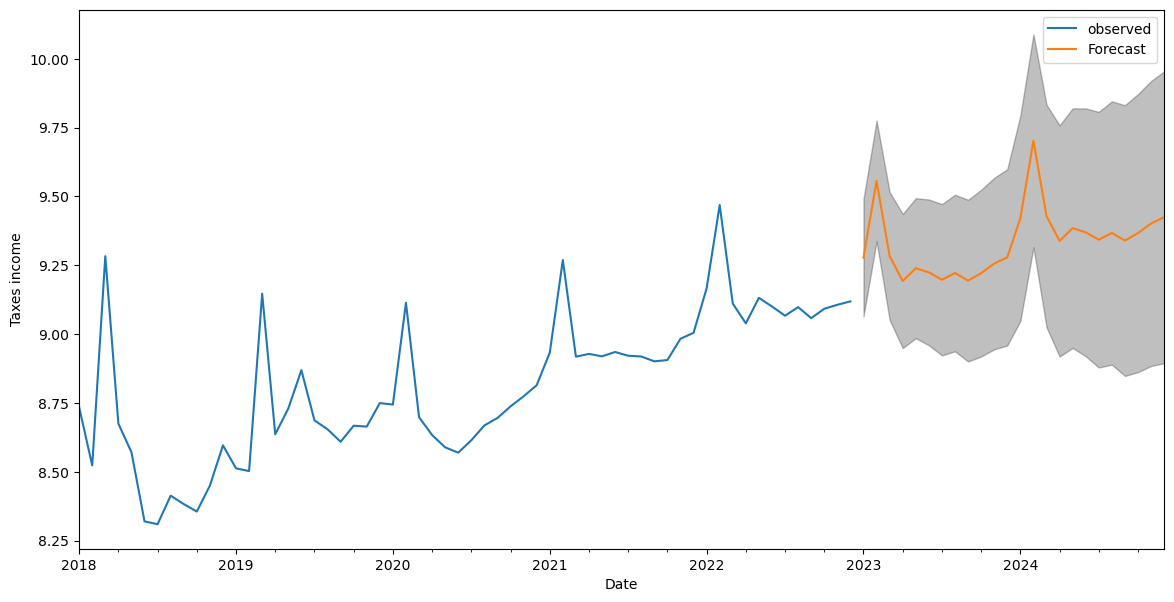

In [90]:
pred_uc1 = results1.get_forecast(steps=24)
pred_ci1 = pred_uc1.conf_int()

ax = np.log(cleancgtaxesnic.Amount)['2018':].plot(label='observed', figsize=(14, 7))
pred_uc1.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci1.index,
                pred_ci1.iloc[:, 0],
                pred_ci1.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Taxes income')

plt.legend()
plt.show()

In [44]:
np.expm1(pred_uc1.predicted_mean)

2023-01-31    10697.581590
2023-02-28    14135.622000
2023-03-31    10761.771006
2023-04-30     9828.362722
2023-05-31    10295.622990
                  ...     
2030-12-31    29659.652341
2031-01-31    34184.501640
2031-02-28    45290.950530
2031-03-31    34466.942505
2031-04-30    31479.806854
Freq: M, Name: predicted_mean, Length: 100, dtype: float64

## Model 2: Autoarima decides D and d order

In [59]:
automodel2 = pm.auto_arima(np.log(cleancgtaxesnic.Amount),
                           error_action='ignore', m=12,start_P=0,
                           start_q=0, start_Q=0, start_p=0,
                           suppress_warnings=True, seasonal=True,
                           stepwise=True, trace=True)
print(automodel2.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-53.324, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-339.447, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-269.717, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-54.752, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-144.267, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-346.046, Time=0.97 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-346.770, Time=1.30 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-348.304, Time=0.32 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-251.817, Time=0.19 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-346.825, Time=1.02 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-294.147, Time=0.77 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=-344.829, Time=1.22 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-274.533, Time=0.17 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=-367.170, Time=0.47 sec
 ARIMA(2,1,0)(0,0,1)[

In [60]:
model2 = sm.tsa.statespace.SARIMAX(np.log(cleancgtaxesnic.Amount),
                                order=(2,1,2),
                                seasonal_order=(1,0,1, 12))
results2 = model2.fit()
print(results2.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.25130D-01    |proj g|=  3.54854D+00

At iterate    5    f= -7.91483D-01    |proj g|=  2.88614D-01

At iterate   10    f= -7.98120D-01    |proj g|=  1.47095D-01

At iterate   15    f= -8.01077D-01    |proj g|=  5.72284D-02

At iterate   20    f= -8.01794D-01    |proj g|=  2.60561D-02

At iterate   25    f= -8.02398D-01    |proj g|=  3.72384D-02

At iterate   30    f= -8.02528D-01    |proj g|=  8.02593D-03

At iterate   35    f= -8.02587D-01    |proj g|=  3.21584D-02

At iterate   40    f= -8.03726D-01    |proj g|=  8.08118D-02

At iterate   45    f= -8.06747D-01    |proj g|=  3.28788D-02

At iterate   50    f= -8.08607D-01    |proj g|=  6.09451D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

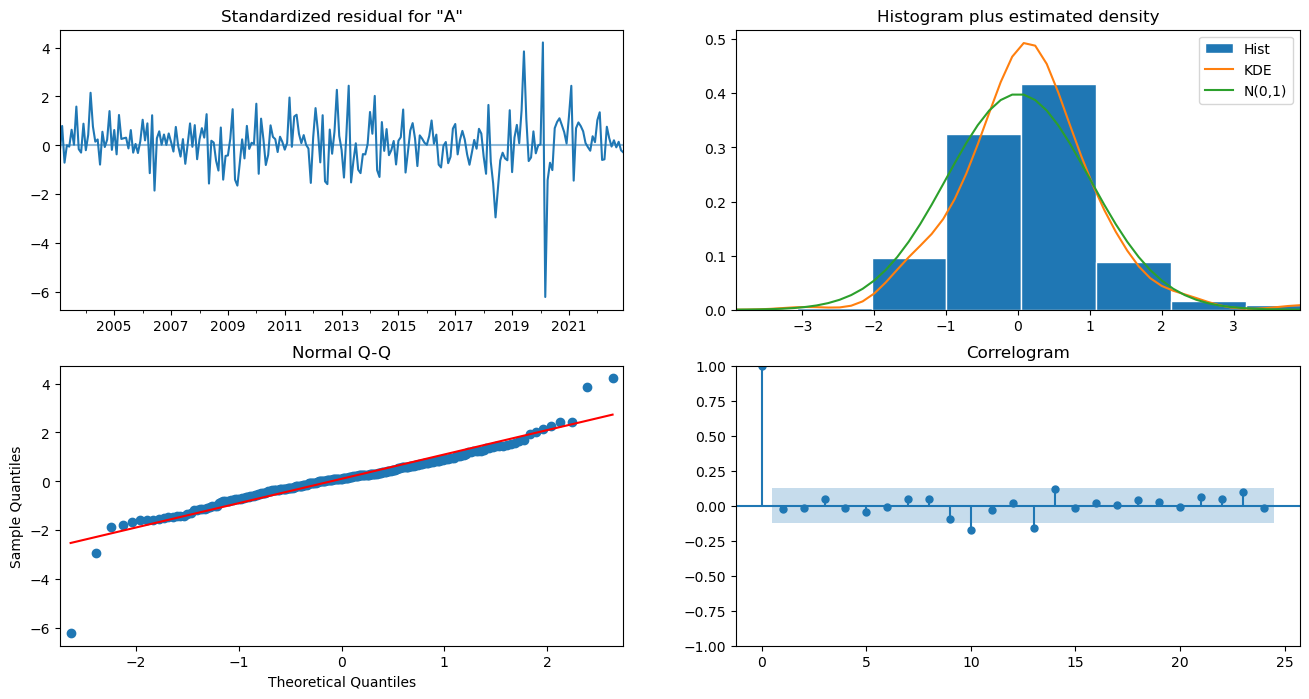

In [61]:
results2.plot_diagnostics(figsize=(16,8),lags=24)
plt.show()

In [62]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = results2.test_normality('jarquebera')[0]
lb_val, lb_p = results2.test_serial_correlation(method='ljungbox',df_adjust=6, lags=24)[0]
het_val, het_p = results2.test_heteroskedasticity('breakvar')[0]


# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(
    results2.filter_results.standardized_forecasts_error[0, results2.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=587.865, p=0.000
Ljung-Box: val=27.568, p=0.069
Heteroskedasticity: val=2.781, p=0.000
Durbin-Watson: d=2.02


**Again, All results, except for Normality test, says that the residuals are good: no serial correlations, and no heterokedasticity. The normal distribution could be because of some extreme (outliers) values because of the crisis in Nicaragua (political crisis and COVID-19 what produced a economic crisis). The results are similar to the Model 1.**

### The predictions and it evaluation

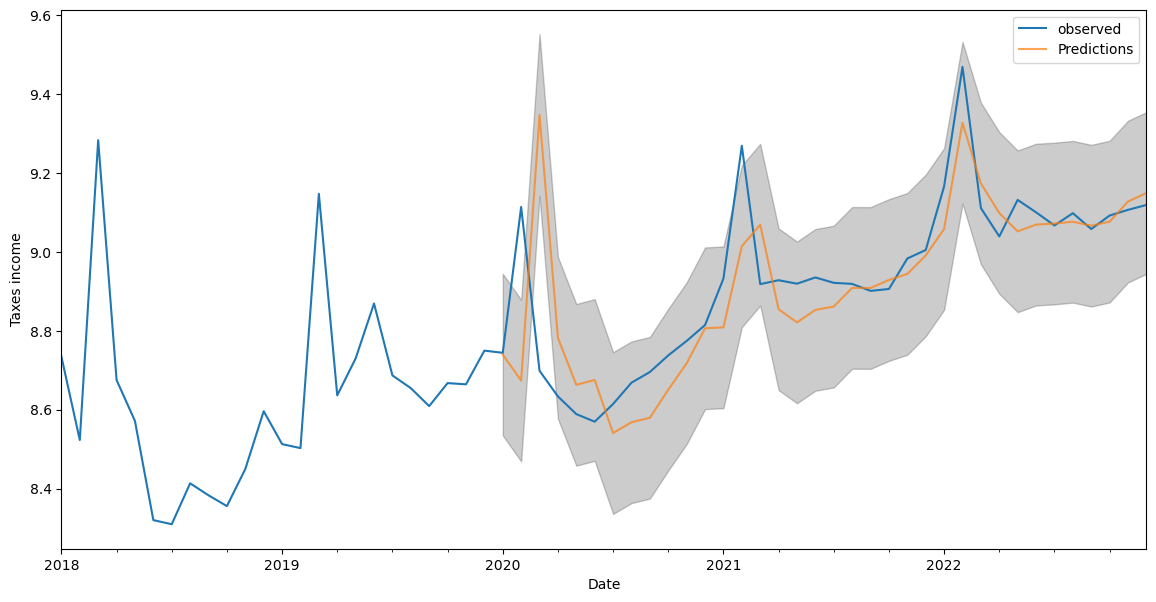

In [77]:
pred2 = results2.get_prediction(start=pd.to_datetime('2020-01-31'), dynamic=False)
pred_ci2 = pred2.conf_int()
ax = np.log(cleancgtaxesnic.Amount)['2018':].plot(label='observed')
pred2.predicted_mean.plot(ax=ax, label='Predictions', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Taxes income')
plt.legend()
plt.show()

In [78]:
y_forecasted2 = pred2.predicted_mean
y_truth2 = np.log(cleancgtaxesnic.Amount)['2020-01-31':]

# Compute the mean square error
mape2 = np.mean(np.abs(y_forecasted2 - y_truth2)/np.abs(y_truth2))
print('Mean Absolute Percentage Error is {}'.format(round(mape2, 4)))

Mean Absolute Percentage Error is 0.0105


In [79]:
print('Mean Absolute Percentage Error for MODEL 1 is {}'.format(round(mape1, 4)))
print('Mean Absolute Percentage Error for MODEL 2 is {}'.format(round(mape2, 4)))

Mean Absolute Percentage Error for MODEL 1 is 0.0116
Mean Absolute Percentage Error for MODEL 2 is 0.0105


In [80]:
print('RMSE MODEL1 IS: ', np.sqrt(results1.mse))
print('RMSE MODEL2 IS: ', np.sqrt(results2.mse))

RMSE MODEL1 IS:  0.4944248649824081
RMSE MODEL2 IS:  0.4397149482406612


**As we can see, both the MAPE (Mean Absolute Percentage Error) and the RMSE (Root Mean Square Error), are lower in Model 2 than in Model 1.**

### The Forecasting

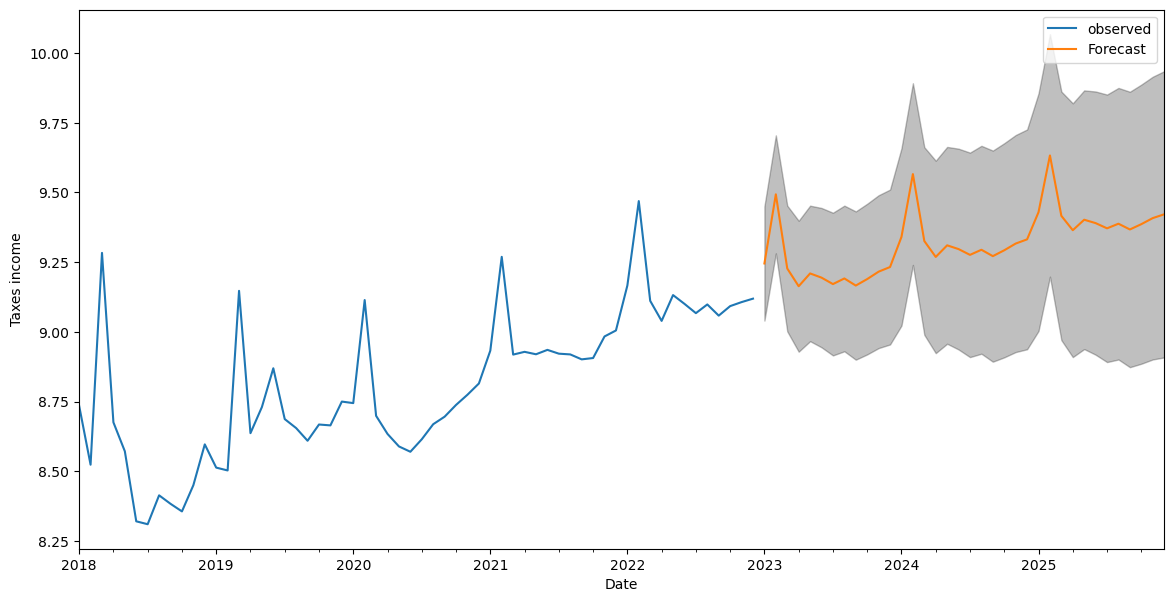

In [84]:
pred_uc2 = results2.get_forecast(steps=36)
pred_ci2 = pred_uc2.conf_int()

ax = np.log(cleancgtaxesnic.Amount)['2018':].plot(label='observed', figsize=(14, 7))
pred_uc2.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Taxes income')

plt.legend()
plt.show()

## Model 3. D=1, d=0

In [65]:
automodel3 = pm.auto_arima(np.log(cleancgtaxesnic.Amount),
                           error_action='ignore', m=12,start_P=0,
                           start_q=0, start_Q=0, start_p=0, D=1,
                           suppress_warnings=True, seasonal=True,
                           stepwise=True, trace=True)
print(automodel3.aic())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-270.640, Time=0.14 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-325.769, Time=0.57 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-311.666, Time=0.42 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-118.915, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-315.617, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-328.371, Time=3.71 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.26 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-283.328, Time=1.50 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-352.264, Time=4.64 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-349.365, Time=0.49 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.04 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=-355.014, Time=1.04 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=-355.043, Time=0.60 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept

In [66]:
model3 = sm.tsa.statespace.SARIMAX(np.log(cleancgtaxesnic.Amount),
                                order=(3,0,0),
                                seasonal_order=(0,1,1, 12))
results3 = model3.fit()
print(results3.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.30985D-01    |proj g|=  5.75194D-01

At iterate    5    f= -7.38358D-01    |proj g|=  7.97351D-01

At iterate   10    f= -7.42225D-01    |proj g|=  4.90437D-02

At iterate   15    f= -7.43918D-01    |proj g|=  3.67321D-01


 This problem is unconstrained.



At iterate   20    f= -7.45376D-01    |proj g|=  1.59626D-01

At iterate   25    f= -7.46692D-01    |proj g|=  1.75145D-02

At iterate   30    f= -7.46734D-01    |proj g|=  2.59762D-02

At iterate   35    f= -7.46740D-01    |proj g|=  6.04206D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     42      1     0     0   4.520D-04  -7.467D-01
  F = -0.74674002176154086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.

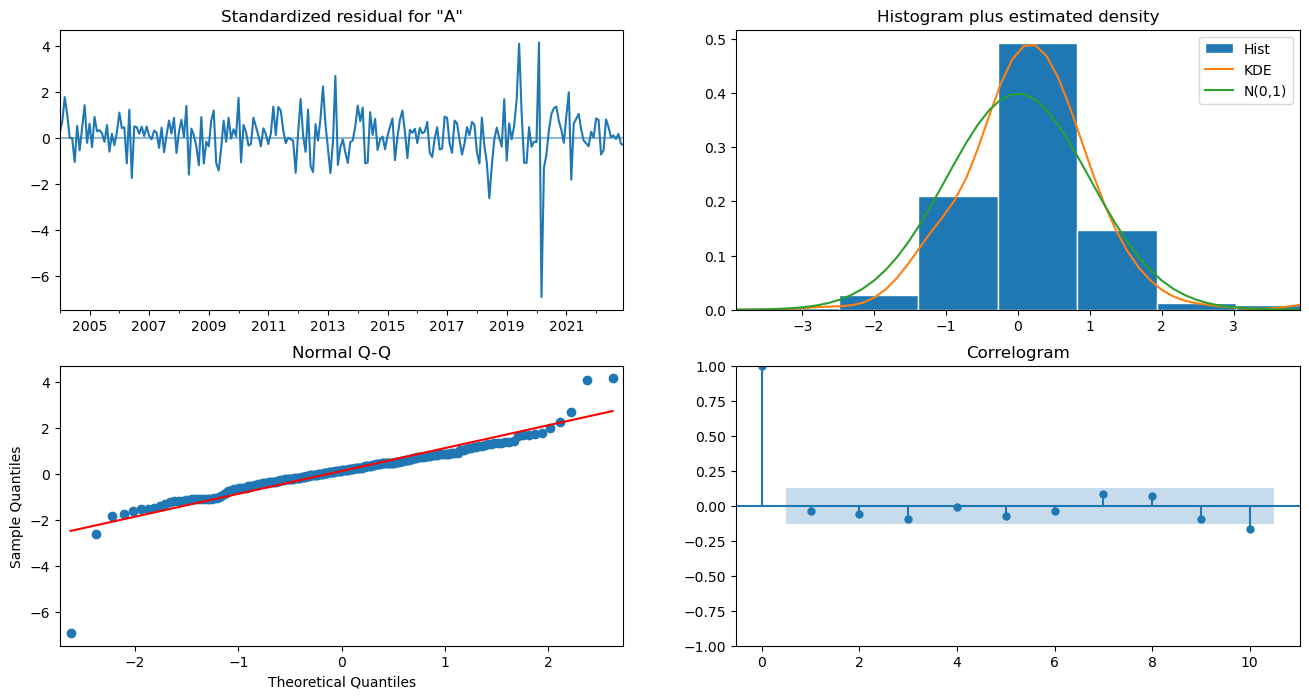

In [67]:
results3.plot_diagnostics(figsize=(16,8))
plt.show()

In [68]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = results3.test_normality('jarquebera')[0]
lb_val, lb_p = results3.test_serial_correlation(method='ljungbox',)[0]
het_val, het_p = results3.test_heteroskedasticity('breakvar')[0]


# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(
    results1.filter_results.standardized_forecasts_error[0, results1.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=1364.043, p=0.000
Ljung-Box: val=34.781, p=0.072
Heteroskedasticity: val=3.093, p=0.000
Durbin-Watson: d=1.99


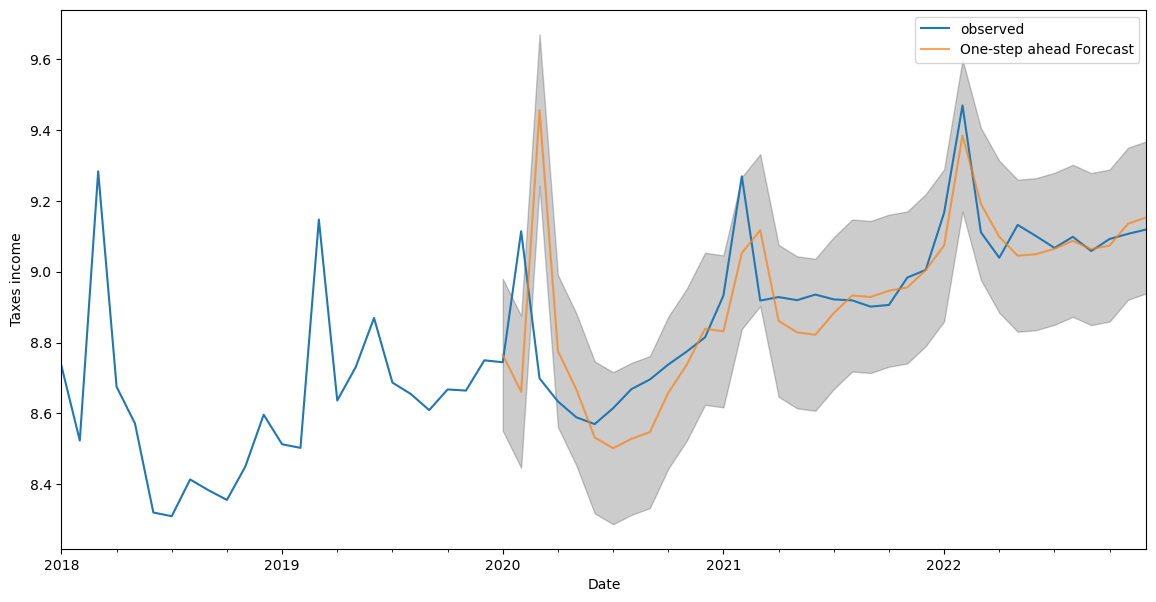

In [81]:
pred3 = results3.get_prediction(start=pd.to_datetime('2020-01-31'), dynamic=False)
pred_ci3 = pred3.conf_int()
ax = np.log(cleancgtaxesnic.Amount)['2018':].plot(label='observed')
pred3.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci3.index,
                pred_ci3.iloc[:, 0],
                pred_ci3.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Taxes income')
plt.legend()
plt.show()

In [82]:
y_forecasted3 = pred3.predicted_mean
y_truth3 = np.log(cleancgtaxesnic.Amount)['2020-01-31':]

# Compute the mean square error
mape3 = np.mean(np.abs(y_forecasted3 - y_truth3)/np.abs(y_truth3))
print('Mean Absolute Percentage Error is {}'.format(round(mape3, 4)))

Mean Absolute Percentage Error is 0.011


In [83]:
print('Mean Absolute Percentage Error model 1 is {}'.format(round(mape1, 4)))
print('Mean Absolute Percentage Error model 2 is {}'.format(round(mape2, 4)))
print('Mean Absolute Percentage Error model 3 is {}'.format(round(mape3, 4)))

Mean Absolute Percentage Error model 1 is 0.0116
Mean Absolute Percentage Error model 2 is 0.0105
Mean Absolute Percentage Error model 3 is 0.011


In [84]:
print('RMSE MODEL1 IS: ', np.sqrt(results1.mse))
print('RMSE MODEL2 IS: ', np.sqrt(results2.mse))
print('RMSE MODEL3 IS: ', np.sqrt(results3.mse))

RMSE MODEL1 IS:  0.4944248649824081
RMSE MODEL2 IS:  0.4397149482406612
RMSE MODEL3 IS:  1.4932996532037892


### The Model 3 Forecast

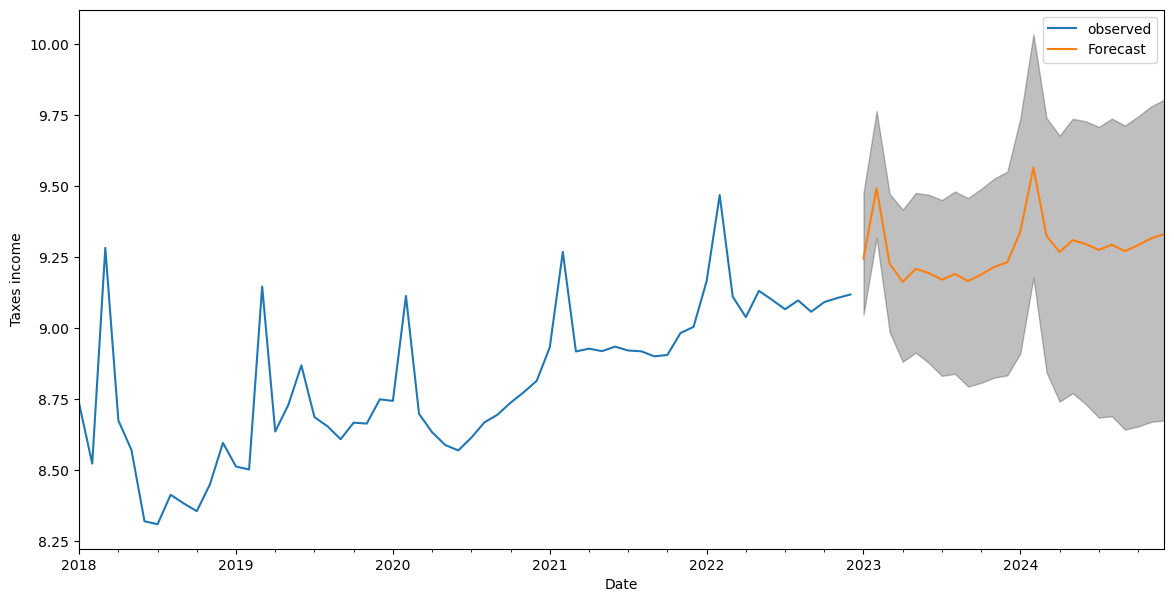

In [86]:
pred_uc3 = results3.get_forecast(steps=24)
pred_ci3 = pred_uc3.conf_int()

ax = np.log(cleancgtaxesnic.Amount)['2018':].plot(label='observed', figsize=(14, 7))
pred_uc2.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci3.index,
                pred_ci3.iloc[:, 0],
                pred_ci3.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Taxes income')

plt.legend()
plt.show()

In [88]:
np.expm1(pred_uc3.predicted_mean).head()

2023-01-31    10533.888375
2023-02-28    13928.888240
2023-03-31    10198.598599
2023-04-30     9413.444107
2023-05-31     9851.691507
Freq: M, Name: predicted_mean, dtype: float64

In [63]:
pred_uc2 = results2.get_forecast(steps=24)

In [64]:
np.expm1(pred_uc2.predicted_mean).head(5)

2023-01-31    10354.735903
2023-02-28    13269.569636
2023-03-31    10169.804249
2023-04-30     9542.565101
2023-05-31     9991.163443
Freq: M, Name: predicted_mean, dtype: float64

In [91]:
model2preds = np.expm1(pred_uc2.predicted_mean)
model1preds = np.expm1(pred_uc1.predicted_mean)
model3preds = np.expm1(pred_uc3.predicted_mean)
predictionsmod1_2 = pd.concat([model2preds, model1preds, model3preds], axis=1, keys=["Mod2","Mod1",'Mod3']) 

predictionsmod1_2.head(3)

,Mod2,Mod1,Mod3
2023-01-31,10354.735903,10697.581590,10533.888375
2023-02-28,13269.569636,14135.622000,13928.888240
2023-03-31,10169.804249,10761.771006,10198.598599


In [92]:
print('RMSE MODEL1 IS: ', np.sqrt(results1.mse))
print('RMSE MODEL2 IS: ', np.sqrt(results2.mse))
print('RMSE MODEL3 IS: ', np.sqrt(results3.mse))

RMSE MODEL1 IS:  0.4944248649824081
RMSE MODEL2 IS:  0.4397149482406612
RMSE MODEL3 IS:  1.4932996532037892


# Conclusion

**In conclusion, the Model is the best one, since has the lowest results for the MAPE and RMSE metrics evaluation. In addition, when the official information about taxes was published in Nicaragua, we can see that the most accurate to the predictions was, in fact, the Model 2.**



| Date    | Mod2            | Mod1            | Actual values     | Diff with MOD2          | Diff with MOD1          |
|---------|-----------------|-----------------|-------------------|-------------------------|-------------------------|
| 31/1/23 |      10,354.74  |      10,697.58  |         10,045.5  |                (309.24) |                (652.08) |
| 28/2/23 |      13,269.57  |      14,135.62  |         13,406.6  |                 137.03  |                (729.02) |
| 31/3/23 |      10,169.80  |      10,761.77  |       10,053.89   |                (115.92) |                (707.89) |